In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageSequence
import cv2
import os
from dataset import Dataset

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
class gifEmbedding():
    def __init__(self):
        self.inputs=  tf.placeholder(tf.float32,(None,32,256,256,1))
        self.nearestTextEmbedding=tf.placeholder(tf.float32,(None,100))
        self.farthestTextEmbedding=tf.placeholder(tf.float32,(None,100))
        self.MAXEPOCHS =10 
        self.currentEpoch = 0
        self.itr = 0
        self.summary_writer_dir = "../summary"
        data = {"batch_size" : 4,"num_frames" : 32 , "img_resize": 256}
        self.dataObj = Dataset(data)
        self.print_freq =5
        self.save_freq = 2000
        self.val_freq = 1000
        self.modelLocation ="../models"
        self.modelName  = "gifEmbedder"
        if not os.path.isdir(self.summary_writer_dir):
            os.mkdir(self.summary_writer_dir)
            
    def model(self):
        with tf.variable_scope("C3D",reuse=tf.AUTO_REUSE):
            conv1 = tf.layers.conv3d(self.inputs,filters =64, kernel_size=(3,3,3),activation = tf.nn.relu,kernel_initializer=tf.initializers.truncated_normal(mean=0,stddev=0.1),strides=(1,2,2),padding ='same')
            
            conv2 = tf.layers.conv3d(conv1,filters =128, kernel_size=(3,3,3),activation = tf.nn.relu,kernel_initializer=tf.initializers.truncated_normal(mean=0,stddev=0.1),strides=(2,2,2),padding ='same')
            
            conv3a = tf.layers.conv3d(conv2,filters =256, kernel_size=(3,3,3),activation = tf.nn.relu,kernel_initializer=tf.initializers.truncated_normal(mean=0,stddev=0.1),strides=(1,1,1),padding ='same')
            conv3b = tf.layers.conv3d(conv3a,filters =256, kernel_size=(3,3,3),activation = tf.nn.relu,kernel_initializer=tf.initializers.truncated_normal(mean=0,stddev=0.1),strides=(2,2,2),padding ='same')
            
            conv4a = tf.layers.conv3d(conv3b,filters =512, kernel_size=(3,3,3),activation = tf.nn.relu,kernel_initializer=tf.initializers.truncated_normal(mean=0,stddev=0.1),strides=(1,1,1),padding ='same')
            conv4b = tf.layers.conv3d(conv4a,filters =512, kernel_size=(3,3,3),activation = tf.nn.relu,kernel_initializer=tf.initializers.truncated_normal(mean=0,stddev=0.1),strides=(2,2,2),padding ='same')
            
            conv5a = tf.layers.conv3d(conv4b,filters =512, kernel_size=(3,3,3),activation = tf.nn.relu,kernel_initializer=tf.initializers.truncated_normal(mean=0,stddev=0.1),strides=(1,1,1),padding ='same')
            conv5b = tf.layers.conv3d(conv5a,filters =512, kernel_size=(3,3,3),activation = tf.nn.relu,kernel_initializer=tf.initializers.truncated_normal(mean=0,stddev=0.1),strides=(2,2,2),padding ='same')
            
            fc6    = tf.layers.flatten(conv5b)
            fc6    = tf.layers.dense(fc6,8192,activation=tf.nn.relu,kernel_initializer=tf.initializers.truncated_normal(0,0.1))
            fc7    = tf.layers.dense(fc6,1024,activation=tf.nn.relu,kernel_initializer=tf.initializers.truncated_normal(0,0.1))
            fc8    = tf.layers.dense(fc7,100,activation=None,kernel_initializer=tf.initializers.truncated_normal(0,0.1),name="Embedding")
        return fc8
    
    def train(self) :
        self.out = model
        self.loss = tf.losses.mean_squared_error(self.nearestTextEmbedding,self.out) - tf.losses.mean_squared_error(self.farthestTextEmbedding,self.out)
        loss_summary  = tf.summary.scalar("lossSummary",self.loss)
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        optimizer=tf.train.AdamOptimizer(learning_rate=self.learningRate)
        with tf.control_dependencies(update_ops): 
            Trainables=optimizer.minimize(loss)
        iters=0
        self.saver = tf.train.Saver()
        config=tf.ConfigProto()
        config.gpu_options.allow_growth=True
        self.sess = tf.Session(config=config)
        train_summary_writer=tf.summary.FileWriter(os.path.join(self.summary_writer_dir,'train'),self.sess.graph)
        test_summary_writer=tf.summary.FileWriter(os.path.join(self.summary_writer_dir,'test'),self.sess.graph)
        self.sess.run(tf.global_variables_initializer())
        
        while not self.dataObj.curr_epoch == self.MAXEPOCHS :
            iters+=1
            gifs,near,far = self.dataObj.load_train()
            t1=time.time()
            _,lval,t_summaries = self.sess.run([Trainables,loss,loss_summary], feed_dict= {self.inputs : gifs ,self.nearestTextEmbedding : near ,self.farthestTextEmbedding : far})
            train_summary_writer.add_summary(t_summaries,iters)
            t2=time.time()      
            if not iters % self.print_freq:
                info = "Model C3D Epoch  {} : Iteration : {} loss value : {:0.4f} \n".format(self.dataObj.curr_epoch,iters,lval)
                print (info)   
                
                
            if not iters % self.save_freq:
                info="Model Saved at iteration {}\n".format(iters)
                print (info)
                self.saveModel(iters)
                
            if not iters % self.val_freq :
                val_gifs,val_near,val_far  = self.dataObj.load_test()
                val_loss,v_summaries = self.sess.run([loss,loss_summary],feed_dict={self.inputs : val_gifs ,self.nearestTextEmbedding:val_near , self.farthestTextEmbedding : val_far})
                test_summary_writer.add_summary(v_summaries, iters)
                info = "Validation Loss at iteration{} : {}\n".format(iters, val_loss)
                print (info)
                
        print ("Training done ")
        self.saveModel(iters)
        
    def saveModel(self,iters):
        if not os.path.exists (self.modelLocation):
            os.makedirs(self.modelLocation)
        self.saver.save(self.sess,os.path.join(self.modelLocation,self.modelName),global_step = iters)
        
    def restoreModel(self):
        
        print ("Using the latest trained model in check point file")
        self.restoreModelPath = tf.train.latest_checkpoint(self.modelLocation)
        print (" Model at {} restored".format(self.restoreModelPath))
            
        if not self.sess is None:
            if self.sess._opened :
                self.sess.close()
        sess=tf.Session()
        self.out = self.model
        saver=tf.train.Saver()
        saver.restore(sess,self.restoreModelPath)
        self.sess=sess
        
    def test(self):
        # restore model
        # for entire test batch of one epoch
        # get the loss values of embedding
        pass
    
    def getgifEmbedding(self,gifarray):
        self.restoreModel()
        output = self.sess.run(self.out,{self.inputs:gifarray})
        return output
        
    def randomRun(self,frames):
        with tf.Session() as sess :
            model =self.model()
            sess.run(tf.global_variables_initializer())
            out =  sess.run(model, feed_dict={self.inputs:frames})
        return out

In [4]:
gif1 = Image.open('sample.gif')
frames = np.array([cv2.resize(np.array(frame.copy()),(256,256)) for frame in ImageSequence.Iterator(gif1)]).reshape(1,-1,256,256,1)
gif2 = Image.open('sample2.gif')
frames2 = np.array([cv2.resize(np.array(frame.copy()),(256,256)) for frame in ImageSequence.Iterator(gif2)]).reshape(1,-1,256,256,1)
gif3 = Image.open('sample3.gif')
frames3 = np.array([cv2.resize(np.array(frame.copy()),(256,256)) for frame in ImageSequence.Iterator(gif3)]).reshape(1,-1,256,256,1)
print frames.shape,frames2.shape,frames3.shape

(1, 63, 256, 256, 1) (1, 23, 256, 256, 1) (1, 27, 256, 256, 1)


In [ ]:
tf.reset_default_graph()
ge=gifEmbedding()
o = ge.randomRun(frames[:,:32,:,:])

In [9]:
from scipy import ndimage
im_array = ndimage.imread("sample.gif")

In [12]:
print (im_array)

[[117  97  78 ... 155 167 169]
 [ 78  78  61 ... 169 155 155]
 [ 41  41  41 ... 155 155 169]
 ...
 [154 154 154 ... 172 169 172]
 [171 154 154 ... 169 169 172]
 [159 154 154 ... 172 169 172]]


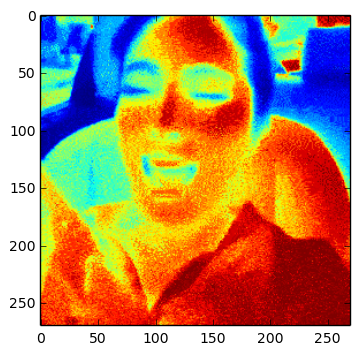

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(im_array,cmap=)